In [10]:
#import packages we need
import imageio
import numpy as np
import scipy.linalg as la
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import animation
%matplotlib inline

In [48]:
def dYdt(Y, t):
    n = len(Y)
    phi = Y[0:int(n / 2)] #we know n is even since Y = [phi phidot]
    phidot = Y[int(n / 2):n]
    
    #get rod tip data (pos vel acc)
    xlsx_files = get_xlsx_files()
    xt = getxt(t)
    yt = getyt(t)
    xtdot = getxtdot(t)
    ytdot = getytdot(t)
    xtddot = getxtddot(t)
    ytddot = getytddot(t)
    
    
    #build little a, then invert and put into M
    #a needs to be n/2 by n/2 np.array/matrix
    A = build_bigA(phi, phidot, mass)
    a = build_a(phi, phidot, A, length, mass)
    ainv = la.inv(a)

    #build RHS vector Q
    Q = build_Q(phi, phidot, mass, length, radius, xt, yt, xtdot, ytdot, xtddot, ytddot, A)
    
    #matrix [I 0;0 ainv]  #see eqn 32 of wang paper
    M = np.zeros((n, n))
    for i in range(n // 2):
        M[i, i] = 1.
    
    for i in range(n // 2):
        for j in range(n // 2):
            M[n // 2 + i, n // 2 + j] = ainv[i, j]

    b = np.zeros((n, 1))
    for i in range(n // 2):
        b[i] = phidot[i]
        b[n // 2 + i] = Q[i]

    Ydot = M@b
    Ydot = Ydot.flatten()

    if xlsx_files:
        df_A = pd.DataFrame(data=A[0:,0:])
        df_A.to_excel("big_a.xlsx")

        df_a = pd.DataFrame(data=a[0:,0:])
        df_a.to_excel("little_a.xlsx")

        df_Q = pd.DataFrame(data=Q[0:,0:])
        df_Q.to_excel("Q.xlsx")

        df_ainv = pd.DataFrame(data=ainv[0:,0:])
        df_ainv.to_excel("ainv.xlsx")

        df_M = pd.DataFrame(data=M[0:,0:])
        df_M.to_excel("M.xlsx")
        
        df_b = pd.DataFrame(data=b[0:,0:])
        df_b.to_excel("b.xlsx")

        df_phi = pd.DataFrame(data=phi[0:])
        df_phi.to_excel("phi.xlsx")

        df_phidot = pd.DataFrame(data=phidot[0:])
        df_phidot.to_excel("phidot.xlsx")

        df_Ydot = pd.DataFrame(data=Ydot[0:])
        df_Ydot.to_excel("Ydot.xlsx")
    
    return Ydot

In [54]:
#helper routines to build RHS vectors and matrices

def build_Q(phi, phidot, mass, length, radius, xt, yt, xtdot, ytdot, xtddot, ytddot, A):
    n = len(phi)
    Q = np.zeros((n, 1))
    gravity = 9.8
    rhoa = 0.0
    CS = 0.005
    ground_level = 0
    ground_spring_constant = 0.0001

    for i in range(n):
        if gety(phi, i, yt, length) > ground_level:
            downward_force = gravity
        else:
            downward_force = gravity * ground_spring_constant
            
        s = mass[i] * 0.5 * length[i] * (downward_force * np.cos(phi[i]) - np.sin(phi[i]) * xtddot+np.cos(phi[i]) * ytddot)

        for k in range(i, n):
            if gety(phi, k, yt, length) > ground_level:
                downward_force = gravity
            else:
                downward_force = gravity * ground_spring_constant

            if k != i:
                s += mass[k] * length[i] * (downward_force * np.cos(phi[i]) - np.sin(phi[i]) * xtddot + np.cos(phi[i]) * ytddot)
        Q[i] = -s

        s = 0
        for k in range(i, n):
            if k != i:
                s += A[i, k] * length[i] * length[k] * phidot[k] ** 2 * np.sin(phi[k] - phi[i])
        Q[i] += s

        # cos(phi[k] - phi[i]) = 1 when i = k therefore cos is not needed
        s = getCD(getRe(phi, phidot, i, radius, length, xtdot, ytdot)) * rhoa * radius[i] *length[i] * getViD(xtdot, ytdot, phi, i) * \
            np.abs(getViD(xtdot, ytdot, phi, i)) * 0.5 * length[i]
        
        for k in range(i, n):
            if k != i:              
                s += getCD(getRe(phi, phidot, k, radius, length, xtdot, ytdot)) * rhoa * radius[k] * length[k] * getViD(xtdot, ytdot, phi, k) * \
                    np.abs(getViD(xtdot, ytdot, phi, k)) * length[i] * np.cos(phi[k] - phi[i])
        Q[i] += -s

        # sin(phi[i] - phi[k]) = 0 when i = k therefore s = 0
        s = 0
        for k in range(i, n):
            if k != i:
                s += CS * rhoa * np.pi * radius[k] * length[k] * getViS(xtdot, ytdot, phi, k) * \
                    np.abs(getViS(xtdot, ytdot, phi, k)) * length[i] * np.sin(phi[i] - phi[k])
        Q[i] += -s
    return Q



def build_a(phi, phidot, A, length, mass):
    #build little a matrix from wang paper
    #mass is vector of segment masses
    #L is vector of segment lengths
    #A is big A matrix 
    n = len(phi)
    a = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                s = mass[j] * length[j] * length[j] * 0.25
                for k in range(i,n):
                    s+= mass[k] * length[k] * length[k]
                a[i, j] = s
            else:
                a[i, j] = A[i, j] * length[i] * length[j] * np.cos(phi[i] - phi[j])
    return a

def build_bigA(phi, phidot, mass):
    #build big A matrix from wang paper
    #mass is vector of masses of segments
    n = len(phi)
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j > i:
                s = 0
                for k in range(j, n):
                    s += mass[k] - 0.5 * mass[j]
                A[i, j] = s
            else:
                s = 0
                for k in range(i, n):
                    s += mass[k] - 0.5 * mass[i]
                A[i, j] = s
    return A

In [14]:
#Reynolds number, drag, and dissipation calculations

def getRe(phi, phidot, i, radius, length, xtdot, ytdot):
    #return the Reynolds number for segment i
    #r is the radius of the segment
    #L is a vector of segment lengths
    Re = 0.
    Re = 1.364e5 * radius[i] * np.sqrt(getxdot(phi, phidot, i, xtdot, length) ** 2 + getydot(phi, phidot, i, ytdot, length) ** 2)
    return Re

def getCD(Re):
    #return drag coefficient in normal direction
    #Re is Reynolds number
    CD = 0.
    if Re < 1:
        return 7.16
    if Re < 34:
        return 7.16 * Re ** -0.42
    if Re < 1580:
        return 3.02 * Re ** -0.165
    else:
        return 0.9
    return CD
#note CS = 0.005 constant dont need a function here

In [51]:
#routines to get positions and velocities

def getx(phi, i, xt, length):
    #get x at position i
    #rod tip x coordinate at xt
    #L is vector of segment Lengths
    s = xt
    for j in range(i):
        s += length[j] * np.cos(phi[j])
    s+= length[i] * np.cos(phi[i]) * 0.5 
    return s

def gety(phi, i, yt, length):
    #get y at position i
    #rod tip y coordinate at yt
    #L is vector of segment Lengths
    s = yt
    for j in range(i):
        s += length[j] * np.sin(phi[j])
    s+= length[i] * np.sin(phi[i]) * 0.5 
    return s

def getxdot(phi, phidot, i, xtdot, length):
    #get xdot at position i
    #rod tip x coordinate movign with velocity xtdot
    #L is vector of segment Lengths
    s = xtdot
    for j in range(i):
        s += -length[i] * np.sin(phi[j]) * phidot[j]
    s+= -length[i] * 0.5 * np.sin(phi[i]) * phidot[i] 
    return s

def getydot(phi, phidot, i, ytdot, length):
    #get ydot at position i
    #rod tip y coordinate moving with velocity ytdot
    #L is vector of segment Lengths
    s = ytdot
    for j in range(i):
        s += length[j] * np.cos(phi[j]) * phidot[j]
    s+= length[i]* 0.5 * np.cos(phi[i]) * phidot[i] 
    return s

def getViD(xtdot, ytdot, phi, i):
    # get VD at i
    return -xtdot * np.sin(phi[i]) + ytdot * np.cos(phi[i])

def getViS(xtdot, ytdot, phi, i):
    # get VS at i
    return xtdot * np.cos(phi[i]) + ytdot * np.sin(phi[i])

In [16]:
#rod tip functions

### static rod for now - can replace with analytic functions or read from data file later 

def getxt(t):
    #get rod tip x position at time t
    xt = 0
    return xt

def getyt(t):
    #get rod tip y position at time t
    yt = 0.5  #3 meter high rod for now
    return yt

def getxtdot(t):
    #get rod tip x velocity at time t
    xtdot = 0
    return xtdot

def getytdot(t):
    #get rod tip y velocity at time t
    ytdot = 0
    return ytdot

def getxtddot(t):
    #get rod tip x acceleration at time t
    xtddot = 0
    return xtddot

def getytddot(t):
    #get rod tip y acceleration at time t
    ytddot = 0
    return ytddot

def get_max_xt()
    #max(array)
    max_value = 0.5
    return max_value

def get_xlsx_files():
    xlsx_files = False
    return xlsx_files

In [17]:
#plot data
def plotdata(phi, length, xt, yt, title=""):
    #change the plot labels and size
    fontsize = 20
    plt.title(title, fontsize=fontsize)
    plt.xlabel("Length", fontsize=fontsize)
    plt.ylabel("Height", fontsize=fontsize)
    plt.rcParams["figure.figsize"] = (20, 15)
    plt.xlim([-1, 1])
    plt.ylim([-0.5, get_max_xt()])
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    n = len(phi) #L also has length n
    x = np.zeros(n)
    y = np.zeros(n) 
    for i in range(n):
        x[i] = getx(phi, i, xt, length)
        y[i] = gety(phi, i, yt, length)
    plt.plot(x, y, 'bo-')
    return plt

In [18]:
def makegif(sol, length, xt, yt):
    images = []
    for i in range(0, 101):
        plotdata(sol[i, 0:Npts], length, xt, yt, f"Time: {i/100} second(s)")
        filepath = f"./images/{i}.png"
        plt.savefig(filepath)
        images.append(imageio.imread(filepath))
        plt.clf()
    imageio.mimsave('Flyline.gif', images, format="GIF", duration=0.1)

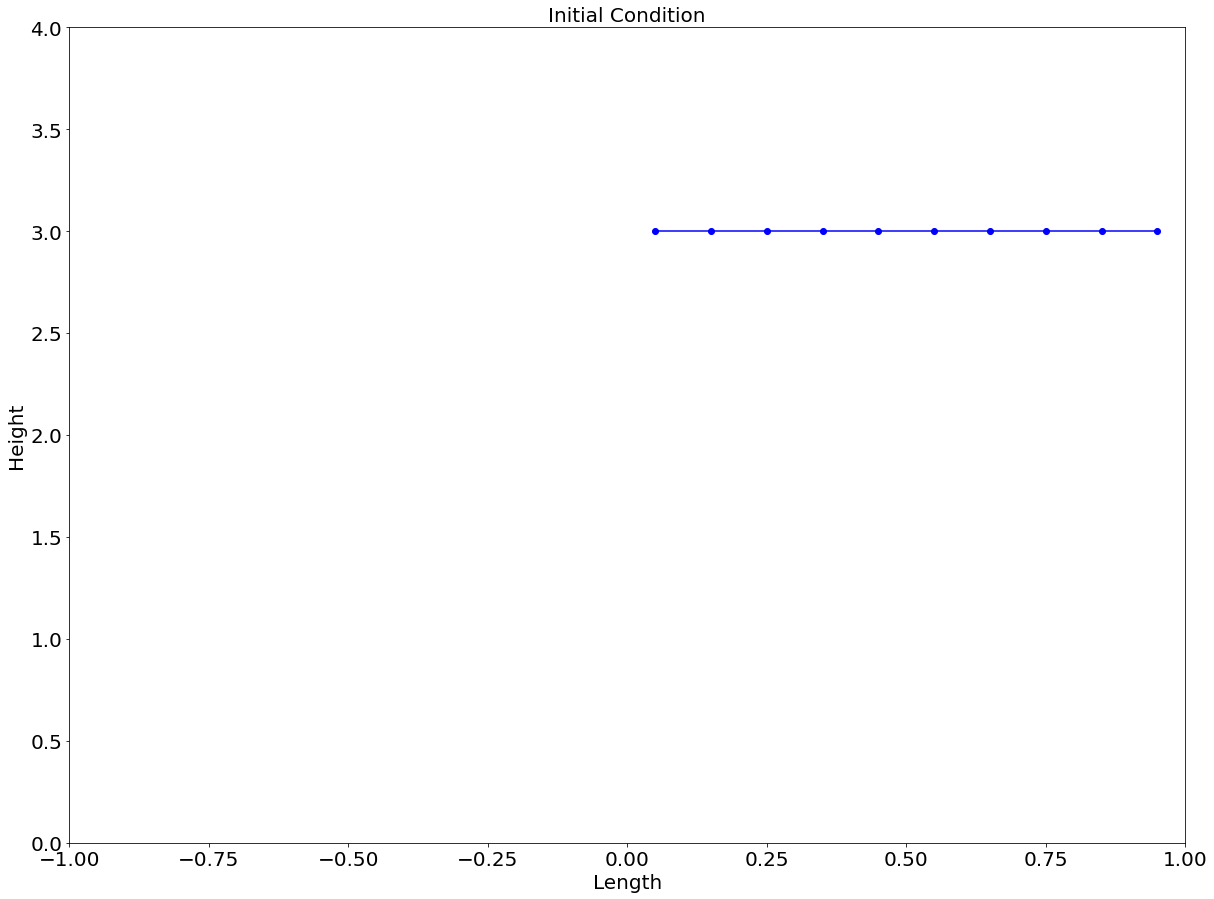

In [55]:
#main driver routine -- 
##--- set up parameter values/initial conditions and call odeint

#parameter values
Npts = 10 #number of points along fly line
t = np.linspace(0., 1., 101) #simulate one second in time in steps of 0.01

length = 0.1 * np.ones(Npts) #can read these in too
radius = 0.001 * np.ones(Npts)
mass = 0.001 * np.ones(Npts)

#inital conditions
##rod tip
xt = getxt(0) 
yt = getyt(0)
##initial angles/velocities
phi_init = np.zeros((Npts, 1))
phidot_init = np.zeros((Npts, 1))
##initial solution vector
Yinit = np.append(phi_init, phidot_init)

#plot initial condition
plotdata(phi_init, length, xt, yt, "Initial Condition")

#call odeint
sol = odeint(dYdt, Yinit, t) #solve the system of ODEs

#do stuff with solution - plot, analyze, etc

In [53]:
makegif(sol, length, xt, yt)

<Figure size 1440x1080 with 0 Axes>